In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
# read data
equity = pd.read_excel('data/data2.xlsx',index_col=0, sheet_name='equity')
factor = pd.read_excel('data/data2.xlsx',index_col=0, sheet_name='factor')

# simple return
factor_return = factor.pct_change().dropna()
equity_return = equity.pct_change().dropna()

In [3]:
# reqExp = required explanation power = determine the number of PC used
reqExp = 0.8

# reqCor = required minimum correlation for the factor with the eigen portfolio
reqCorr = 0.4

# reqFcorr = maximum between-factor correlation, to avoid multicollinearity
reqFcorr = 0.7

In [4]:
# calculate covariance matrix
eqt_ret_cov = equity_return.cov().to_numpy()

# calculate eigen values and eigen vectors
w, v = np.linalg.eig(eqt_ret_cov)

# find required number of PC needed to reach reqExp
tmp = w / w.sum()
reqPC = np.where(tmp.cumsum()>reqExp)[0][0]+1

# df for factor loadings
pca_loadings_df = pd.DataFrame(v[:, :reqPC], index=equity_return.columns, columns=['PC{}'.format(i+1) for i in range(reqPC)])
pca_loadings_df

# The first PC seems to be a general level of global returns, all have the same signs with mean of 21%
# The second PC seems to reflect a contrast of developed markets vs emerging markets
# The third PC seems to reflect the locational difference between fast-growing Asian economies vs the western world
# We seem not able to assign themes to the remaining PCs

,PC1,PC2,PC3
NKY Index,0.208945,0.134021,0.166105
HSI Index,0.276945,-0.112564,-0.254427
AS51 Index,0.161056,0.073183,0.053715
HSCEI Index,0.363000,-0.344323,-0.301775
SHSZ300 Index,0.278598,-0.740937,0.537684
TWSE Index,0.210198,0.003236,-0.208525
KOSPI Index,0.197664,0.001079,-0.117443
NIFTY Index,0.261079,0.054008,-0.353639
FSSTI Index,0.231044,-0.002826,-0.140376
SPX Index,0.176583,0.117475,0.061978


<AxesSubplot:>

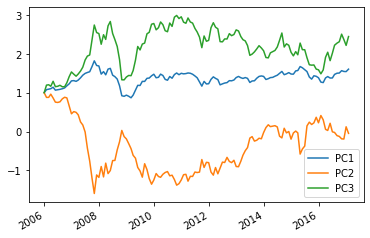

In [6]:
# eigen portfolios
pca_port_df = pd.DataFrame(np.dot(equity, (pca_loadings_df/pca_loadings_df.sum()).to_numpy()),index=equity.index, columns=['PC{}'.format(i+1) for i in range(reqPC)])

# change starting value to 1
pca_port_df = pca_port_df/pca_port_df.iloc[0, :]

pca_port_df.plot()

In [18]:
### This section is to find the most relevant factors (actual assets/indics) to represent the principal components (eigen portfolios)
# the idea is that we believe there are real fundamental factors that are driving each Principal components.
# For example, the first PC correspond to general global return, so it is driven by global economic growth
# Second PC may correspond to contrast of developed markets vs emerging markets, and emerging markets are more affected by flow (reflected by currency indics)
# So we want to reconcile the PC with those fundamental factors

factors_list = set()
for pca_i in range(pca_port_df.shape[1]):
    pca_port_i = pca_port_df.iloc[:, pca_i]
    for factor_i in range(factor_return.shape[1]):
        r, p = pearsonr(factor_return.iloc[:, factor_i], pca_port_i)
        if abs(r) > reqCorr:
            factors_list = factors_list.union({factor_return.columns[factor_i]})

selected_factors = factor_return[list(factors_list)]
selected_factors.corr()

,HG1 COMDTY,GBP Curncy,INR CURNCY,CDBR1U5 Index,XOVER CDSI GENERIC 5Y Corp,CL1 COMDTY,EUR Curncy,AUDJPY CURNCY,CITLY1U5 Index,CJGB1U5 Index,DXY CURNCY,CO1 COMDTY,SPAIN CDS USD SR 5Y Corp
HG1 COMDTY,1.000000,0.490287,-0.331265,-0.330244,-0.227584,0.536193,0.472806,0.525401,-0.236168,-0.267981,-0.517309,0.540435,-0.160837
GBP Curncy,0.490287,1.000000,-0.379350,-0.400997,-0.360181,0.553210,0.587618,0.518967,-0.366126,-0.367654,-0.665215,0.570868,-0.245702
INR CURNCY,-0.331265,-0.379350,1.000000,0.303732,0.379140,-0.242549,-0.500469,-0.493160,0.329592,0.286693,0.519762,-0.270073,0.232642
CDBR1U5 Index,-0.330244,-0.400997,0.303732,1.000000,0.366102,-0.178282,-0.351831,-0.441944,0.578288,0.414617,0.348249,-0.179346,0.452296
XOVER CDSI GENERIC 5Y Corp,-0.227584,-0.360181,0.379140,0.366102,1.000000,-0.252025,-0.249635,-0.463553,0.593700,0.488723,0.252425,-0.262335,0.559313
CL1 COMDTY,0.536193,0.553210,-0.242549,-0.178282,-0.252025,1.000000,0.475898,0.538083,-0.261401,-0.263325,-0.517734,0.934004,-0.198696
EUR Curncy,0.472806,0.587618,-0.500469,-0.351831,-0.249635,0.475898,1.000000,0.543086,-0.329391,-0.249951,-0.973054,0.459836,-0.279960
AUDJPY CURNCY,0.525401,0.518967,-0.493160,-0.441944,-0.463553,0.538083,0.543086,1.000000,-0.502890,-0.360804,-0.501305,0.484752,-0.461104
CITLY1U5 Index,-0.236168,-0.366126,0.329592,0.578288,0.593700,-0.261401,-0.329391,-0.502890,1.000000,0.576734,0.308386,-0.259823,0.811170
CJGB1U5 Index,-0.267981,-0.367654,0.286693,0.414617,0.488723,-0.263325,-0.249951,-0.360804,0.576734,1.000000,0.280736,-0.291630,0.511163


In [19]:
# From correlation plot, DXY and EUR are highly correlated. This is intuitive, since a strong proportion of DXY basket is EUR, and they
# both represent flow to developed markets. So we only need to keep one. We keep DXY

# same for CO1, CL1. they are both oil futures (Brent VS WTI). We keep any one of them
del selected_factors['DXY CURNCY']
del selected_factors['CL1 COMDTY']
selected_factors.corr()

,HG1 COMDTY,GBP Curncy,INR CURNCY,CDBR1U5 Index,XOVER CDSI GENERIC 5Y Corp,EUR Curncy,AUDJPY CURNCY,CITLY1U5 Index,CJGB1U5 Index,CO1 COMDTY,SPAIN CDS USD SR 5Y Corp
HG1 COMDTY,1.000000,0.490287,-0.331265,-0.330244,-0.227584,0.472806,0.525401,-0.236168,-0.267981,0.540435,-0.160837
GBP Curncy,0.490287,1.000000,-0.379350,-0.400997,-0.360181,0.587618,0.518967,-0.366126,-0.367654,0.570868,-0.245702
INR CURNCY,-0.331265,-0.379350,1.000000,0.303732,0.379140,-0.500469,-0.493160,0.329592,0.286693,-0.270073,0.232642
CDBR1U5 Index,-0.330244,-0.400997,0.303732,1.000000,0.366102,-0.351831,-0.441944,0.578288,0.414617,-0.179346,0.452296
XOVER CDSI GENERIC 5Y Corp,-0.227584,-0.360181,0.379140,0.366102,1.000000,-0.249635,-0.463553,0.593700,0.488723,-0.262335,0.559313
EUR Curncy,0.472806,0.587618,-0.500469,-0.351831,-0.249635,1.000000,0.543086,-0.329391,-0.249951,0.459836,-0.279960
AUDJPY CURNCY,0.525401,0.518967,-0.493160,-0.441944,-0.463553,0.543086,1.000000,-0.502890,-0.360804,0.484752,-0.461104
CITLY1U5 Index,-0.236168,-0.366126,0.329592,0.578288,0.593700,-0.329391,-0.502890,1.000000,0.576734,-0.259823,0.811170
CJGB1U5 Index,-0.267981,-0.367654,0.286693,0.414617,0.488723,-0.249951,-0.360804,0.576734,1.000000,-0.291630,0.511163
CO1 COMDTY,0.540435,0.570868,-0.270073,-0.179346,-0.262335,0.459836,0.484752,-0.259823,-0.291630,1.000000,-0.178399


In [28]:
## Now that we have found some good real-world representations of eigen portfolios, lets see how well they explain volatility of individual stocks
## we will use linear regression for this purpose

# standardize returns. This is to remove keep intercept term of regression close to 0
selected_factors = (selected_factors - selected_factors.mean()) / selected_factors.std()
eqty_ret_std = (equity_return - equity_return.mean()) / equity_return.std()

X = selected_factors.to_numpy()
X = sm.add_constant(X)
r_sqrt = list()
betas = list()
# Run regression on Equity returns using selected factors as predictors
for equity_i in range(eqty_ret_std.shape[1]):
    model = sm.OLS(endog=eqty_ret_std.iloc[:, equity_i], exog=X)
    result = model.fit()
    r_sqrt.append(result.rsquared)
    betas.append(result.params)

r_sqrt_df =  pd.DataFrame(r_sqrt, index=equity_return.columns, columns=['R squared'])
# R squared are pretty high for some indics. This means over half of the volatility can actually be represented the fundamental factors
# which are commodity / currency / pairs that represent flow
r_sqrt_df

,R squared
NKY Index,0.670708
HSI Index,0.655516
AS51 Index,0.604546
HSCEI Index,0.547248
SHSZ300 Index,0.251006
TWSE Index,0.544687
KOSPI Index,0.513291
NIFTY Index,0.543757
FSSTI Index,0.679509
SPX Index,0.687608


In [30]:
betas_df = pd.DataFrame(betas, index=equity_return.columns)
betas_df = betas_df.T
betas_df.index = ['cost'] + list(selected_factors.columns)

# We can also look at individual importance of each factor to each index.
# Intercepts are all 0, good
# Let's interpret SPX Index together
# The factor with highest betas is AUDJPY CURNCY, this pair represent bullishness.
# Because JPY is an indicator of flow to equity (when economy is good, ppl borrow JPY at zero rate, sell for USD and enter US stock market)
# AUD represent flow to commodity, so when AUD is strengthening, it means economy is doing well, demand is strong and commodity is doing well
# so AUD/JPY represent bulllishness of stock market. This is also the largest coefficient in the regression! So the method is accurate!
betas_df

,NKY Index,HSI Index,AS51 Index,HSCEI Index,SHSZ300 Index,TWSE Index,KOSPI Index,NIFTY Index,FSSTI Index,SPX Index,NDX Index,ibov Index,SX5E Index,UKX Index,CAC Index,DAX Index,SMI Index,IBEX Index,OMX Index,AEX Index
cost,1.387779e-17,0.000000,5.551115e-17,-9.714451e-17,-4.163336e-17,1.387779e-17,0.000000,-3.469447e-17,6.938894e-18,-4.163336e-17,-6.938894e-17,0.000000,0.000000,-1.387779e-17,-2.775558e-17,-2.775558e-17,0.000000,0.000000,1.387779e-17,5.551115e-17
HG1 COMDTY,-1.005607e-01,0.066758,1.726988e-01,4.351484e-02,2.518320e-01,2.796987e-01,0.242369,-2.444736e-02,1.279062e-01,1.275011e-01,8.672764e-02,0.148489,0.026270,1.612749e-01,6.188725e-02,2.242106e-02,0.030502,-0.048687,1.135523e-01,1.085401e-01
GBP Curncy,3.392961e-02,0.125854,-1.261096e-01,3.410174e-02,2.003551e-01,-5.845798e-02,-0.069187,-3.310325e-02,9.817887e-02,-9.546324e-02,-3.317459e-02,-0.104757,-0.050139,-4.305053e-01,-1.018734e-01,-6.080127e-02,-0.035663,0.089241,-6.702180e-02,-5.856575e-02
INR CURNCY,-4.243978e-02,-0.286086,-1.624182e-01,-2.391237e-01,-1.430863e-01,-2.133087e-01,-0.191613,-4.585158e-01,-3.679849e-01,-1.444375e-01,-1.765333e-01,-0.231285,-0.190106,-2.106655e-01,-1.493437e-01,-2.326286e-01,-0.128537,-0.169983,-2.103930e-01,-2.388864e-01
CDBR1U5 Index,-1.285647e-03,-0.006657,-1.799961e-02,-6.735372e-02,-6.680641e-02,1.854285e-01,0.038030,1.946485e-02,-5.460723e-03,-1.110401e-01,-3.541904e-02,-0.037057,-0.103385,-1.677043e-02,-6.667924e-02,-1.092989e-01,-0.244552,-0.030912,3.519066e-02,-7.806978e-02
XOVER CDSI GENERIC 5Y Corp,-1.674315e-01,0.013841,-2.296455e-01,9.297115e-02,2.439899e-03,8.520106e-03,0.011945,2.952674e-02,-6.040653e-02,-2.845529e-01,-2.268638e-01,-0.076029,-0.386604,-3.171300e-01,-4.108755e-01,-4.215397e-01,-0.275731,-0.222369,-1.996423e-01,-2.369934e-01
EUR Curncy,-2.032465e-01,-0.016862,-1.984456e-02,-3.428643e-03,-1.395044e-01,2.388101e-02,-0.045851,-3.245020e-02,-9.685558e-02,8.800270e-02,-1.329616e-02,0.072038,-0.059417,1.369429e-01,-6.273237e-02,-1.483616e-01,-0.250501,0.108057,-2.106307e-01,-2.772520e-01
AUDJPY CURNCY,6.856041e-01,0.275032,1.461474e-01,3.563438e-01,1.126354e-01,3.068510e-01,0.201173,2.140814e-01,2.133552e-01,2.036312e-01,2.019528e-01,0.183564,0.096136,1.263424e-01,1.014653e-01,1.500025e-01,0.131382,-0.012734,3.062074e-01,1.336515e-01
CITLY1U5 Index,5.126678e-02,0.075903,-9.079438e-02,1.266024e-01,-1.547771e-02,-7.367683e-02,-0.177334,-1.131865e-01,-6.005229e-03,-7.073993e-02,-9.701876e-02,0.008892,-0.068546,7.680230e-02,-1.064620e-01,3.389096e-02,0.048430,-0.122113,-2.728468e-01,-1.188901e-01
CJGB1U5 Index,-2.917333e-01,-0.185100,-2.540171e-01,-1.464763e-01,1.166572e-01,-4.362680e-02,-0.207978,-1.471911e-01,-2.125362e-01,-1.828926e-01,-1.073725e-01,-0.078252,-0.153817,-2.600586e-01,-1.836148e-01,-1.801235e-01,-0.216182,-0.093270,-7.557957e-02,-1.676246e-01
